# Fine-Tuning a Small LLM with LoRA for Automated Paper Review Insights (code)

This notebook demonstrates how to fine-tune a small language model (LLM) using LoRA for automated paper review analysis. It covers data preparation, model training, prediction generation, and evaluation of review quality and scoring.

In [2]:
cd Automated_Paper_Review

/home/disi/Automated_Paper_Review


In [ ]:

# ---------------------- IMPORTS ----------------------
%pip install -r requirements.txt
import pandas as pd
import os
import torch
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments, Trainer
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from sklearn.model_selection import train_test_split
from datasets import Dataset
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error,root_mean_squared_error,r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
from bert_score import score as bertscore
#from huggingface_hub import login
#login("your_token_here")  # Uncomment and replace with your token if needed


Note: you may need to restart the kernel to use updated packages.


### Loading and cleaning data
This cell loads and preprocesses the paper review dataset. It reads the Excel file, removes incomplete entries, cleans text fields, merges reviews for duplicate titles, and prepares the data for training and evaluation. Several utility functions are defined for cleaning and extracting relevant information from the dataset.

In [4]:
# ---------------------- LOAD & CLEAN DATA ----------------------

df = pd.read_excel("./data/tp_2017conference.xlsx")

# Drop rows missing title/abstract/review
df = df.dropna(subset=["title", "abstract", "review"])

# Clean abstract field
df["abstract"] = df["abstract"].str.replace("Abstract:###", "", regex=False).str.strip()

# Deduplicate by title (merge reviews)
grouped = df.groupby("title").agg({
    "abstract": "first",  # assume same abstract
    "review": lambda r: "\n\n".join(r),  # concat reviews
    "rate": list,
    "confidence": list,
    "decision": "first"
}).reset_index()

# CLEANING FUNCTIONS

def clean_text(text):
    '''Rimuove caratteri non stampabili, tag HTML, codifiche Unicode e spazi extra'''
    if not isinstance(text, str):
        return ""
    text = re.sub(r"[\x00-\x1F\x7F]", " ", text)
    text = re.sub(r"<[^>]+>", "", text)
    text = re.sub(r"_x[0-9a-fA-F]{4}_", " ", text)
    text = re.sub(r"\\s+", " ", text)
    return text.strip()

def clean_dataset(df):
    '''Pulisce il DataFrame rimuovendo righe con campi essenziali mancanti e applicando clean_text'''
    # Tieni solo righe con i campi essenziali
    df = df.dropna(subset=["title", "abstract", "review"]).reset_index(drop=True)

    # Applica clean_text su tutte le colonne testuali
    for col in ["title", "abstract", "review"]:
        df[col] = df[col].map(clean_text)

    return df

def clean_response(text):
    """Rimuove token speciali e fallback in caso di errore"""
    if "<|start_header_id|>assistant<|end_header_id|>\n" in text:
        text = text.split("<|start_header_id|>assistant<|end_header_id|>\n", 1)[-1]
    return text.replace("<|eot_id|>", "").strip()

def extract_number(text):
    """Estrae numero da rate/confidence tipo 'Rating:###7: ...' """
    if pd.isna(text):
        return None
    match = re.search(r"(\d+)", str(text))
    return int(match.group(1)) if match else None

# APPLY CLEANING
grouped = clean_dataset(grouped)

# Rimozione del campo decision (evita leakage)
if "decision" in grouped.columns:
    grouped = grouped.drop(columns=["decision"])

# Normalizzazione numerica rate/confidence
grouped["rating_num"] = grouped["rate"].apply(lambda lst: extract_number(lst[0]) if isinstance(lst, list) and lst else None)
grouped["confidence_num"] = grouped["confidence"].apply(lambda lst: extract_number(lst[0]) if isinstance(lst, list) and lst else None)

# Split into train/val/test
train_val, test = train_test_split(grouped, test_size=0.2, random_state=42)
train, val = train_test_split(train_val, test_size=0.1, random_state=42)

# Save for future use
train.to_csv("./data/train.csv", index=False)
val.to_csv("./data/val.csv", index=False)
test.to_csv("./data/test.csv", index=False)

### Model upload and preparation
This cell initializes the tokenizer and loads the Llama-3 model for causal language modeling. It sets up quantization with BitsAndBytes for efficient memory usage and configures the tokenizer for padding and device placement. The model is loaded with automatic device mapping to utilize available GPU resources.

In [5]:
# ---------------------- TOKENIZER & MODEL LLAMA ----------------------

model_name = "meta-llama/Llama-3.2-3B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"


model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",  # this will choose GPU
    quantization_config=bnb_config,
    torch_dtype=torch.float16
)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

This cell prints the device map used by the loaded Llama-3 model, showing how model layers are distributed across available hardware (such as GPUs or CPUs). This helps verify that the model is utilizing the intended devices for inference and training.

In [6]:
print(model.hf_device_map)

{'': 0}


This cell defines the function used to build prompts for the language model. It formats the paper's title, abstract, and review into a structured input, instructing the model to generate strengths, weaknesses, a numeric rating, and a confidence score in a specific format.

In [7]:
# ---------------------- PROMPT FUNCTION ----------------------
def build_prompt(example):
    title = clean_text(example["title"])
    abstract = clean_text(example["abstract"])
    review = clean_text(example["review"])
    return (
        f"<|begin_of_text|><|start_header_id|>user<|end_header_id|>\n"
        f"Title: {title}\n"
        f"Abstract: {abstract}\n"
        f"Review: {review}\n"
        "Write a structured peer review with this exact format:\n\n"
        "Strengths:\n1. ...\n2. ...\n\n"
        "Weaknesses:\n1. ...\n2. ...<|eot_id|>\n"
        "Then, give a numeric rating (1-10) and a confidence score (1-5) in this format:\n"
        "Rating: <number>\n"
        "Confidence: <number><|eot_id|>\n"
        "<|start_header_id|>assistant<|end_header_id|>\n"
    )

This cell provides functions to generate structured peer reviews using the language model. It takes each paper, builds a prompt, and uses the model to produce strengths, weaknesses, rating, and confidence predictions. The second function applies this process to an entire DataFrame, saving the generated reviews and handling errors during generation.

In [8]:
# ---------------------- GENERATE STRENGTHS AND WEAKNESSES (both zero-shot/ft) ----------------------
def generate_review(model, tokenizer, paper, max_new_tokens=300):
    prompt = build_prompt(paper)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.inference_mode():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.2,
            top_p=0.9,
            use_cache=True
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=False)
    decoded = clean_response(decoded)
    return decoded

def generate_reviews_for_df(df, model, tokenizer, output_col="generated_review", output_file=None):
    preds = []

    print(f"Generating predictions for {len(df)} papers")

    model.eval()
    model.config.use_cache = True
    if hasattr(model, "gradient_checkpointing_disable"):
        model.gradient_checkpointing_disable()

    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            response = generate_review(model, tokenizer, row)
            preds.append(response)
        except Exception as e:
            preds.append(f"[ERROR: {e}]")
            print(f"Error on row {i}: {e}")

    df[output_col] = preds

    if output_file:
        df.to_csv(output_file, index=False)
        print(f"Saved to {output_file}")

    return df

#### Distillation
These two cells generate structured peer reviews for the training and validation sets using the base language model. They clean the training and validation data, apply the review generation function, and save the resulting structured reviews to two CSV files for use as supervised targets in fine-tuning.

In [ ]:
# ---------------------- STRUCTURE REVIEW (Distillation) ----------------------

# Generate structured reviews (this is your supervised target)
train = pd.read_csv("./data/train.csv")

#CLEANING
train= clean_dataset(train)
train_df = generate_reviews_for_df(train, model, tokenizer, output_file="./data/train_structured.csv")
train_df.to_csv("./data/train_structured.csv", index=False)


Generating predictions for 350 papers


100%|██████████| 350/350 [1:18:00<00:00, 13.37s/it]

Saved to train_structured.csv


In [ ]:
val = pd.read_csv("./data/val.csv")
val = clean_dataset(val)
val_df = generate_reviews_for_df(val, model, tokenizer, output_file="./data/val_structured.csv")
val_df.to_csv("./data/val_structured.csv", index=False)

Generating predictions for 40 papers


100%|██████████| 40/40 [08:50<00:00, 13.27s/it]

Saved to val_structured.csv


### LoRa configuration
This cell configures the model for parameter-efficient fine-tuning using LoRA (Low-Rank Adaptation). It prepares the model for k-bit training and sets up the LoRA configuration, specifying target modules and hyperparameters. The LoRA adapter is then applied to the model to enable efficient adaptation during fine-tuning.

In [11]:
# ---------------------- LoRA CONFIG ----------------------

model_ft = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model_ft = get_peft_model(model_ft, lora_config)

This cell prepares the training and validation datasets for fine-tuning. It builds prompt-response pairs from the generated reviews, tokenizes the data for the language model, and removes unnecessary columns to create datasets suitable for supervised training.

In [12]:
# ---------------------- FINE-TUNING PREP ----------------------
def ft_prompt(example):
    prompt = build_prompt(example)
    response = example["generated_review"].strip() + "\n<|eot_id|>"
    return {"prompt": prompt, "response": response}

train_dataset = Dataset.from_pandas(train_df).map(ft_prompt)
val_dataset = Dataset.from_pandas(val_df).map(ft_prompt)

def tokenize(example):
    tokens= tokenizer(
        example["prompt"] + example["response"], 
        truncation=True, 
        padding="max_length", 
        max_length=300
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

train_dataset = train_dataset.map(tokenize)
val_dataset = val_dataset.map(tokenize)

drop_cols = list(set(train_df.columns) | {"prompt", "response"})
train_dataset = train_dataset.remove_columns([c for c in drop_cols if c in train_dataset.column_names])
val_dataset = val_dataset.remove_columns([c for c in drop_cols if c in val_dataset.column_names])

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

### Training
This cell sets up and runs the training loop for fine-tuning the model using the Hugging Face Trainer API. It defines training arguments such as batch size, evaluation strategy, number of epochs, and learning rate, then starts the training process and saves the fine-tuned model and tokenizer.

In [13]:
# ---------------------- TRAINING ----------------------

training_args = TrainingArguments(
    output_dir="./model/finetuned-llama3",
    remove_unused_columns=False,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="steps",
    save_strategy="steps",
    logging_steps=10,
    save_steps=100,
    eval_steps=100,
    num_train_epochs=3,
    learning_rate=2e-5,
    fp16=True,
    report_to="none"
)

trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()

# Save model
model_ft.save_pretrained("./model/finetuned-llama3-lora")
tokenizer.save_pretrained("./model/finetuned-llama3-lora")

/tmp/ipykernel_3401/3718651729.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/home/disi/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variant

Step,Training Loss,Validation Loss
100,2.749900,2.605802
200,2.585000,2.529271
300,2.651100,2.512285
400,2.545100,2.505570
500,2.518100,2.502952


/home/disi/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/disi/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/disi/miniconda3/lib/python3.12/site-packages/torch/utils/check

('./model/finetuned-llama3-lora/tokenizer_config.json',
 './model/finetuned-llama3-lora/special_tokens_map.json',
 './model/finetuned-llama3-lora/chat_template.jinja',
 './model/finetuned-llama3-lora/tokenizer.json')

### Generating reviews using zero-shot and fine-tuning
This cell performs inference on the test set using the base language model. It cleans the test data, generates zero-shot structured peer reviews, and saves the predictions to a CSV file for later evaluation.

In [14]:
# ---------------------- INFERENCE ON TEST SET ----------------------
# Generate zero-shot reviews
test_df = pd.read_csv("./data/test.csv")
test_df = clean_dataset(test_df)

generate_reviews_for_df(
    df=test_df,
    model=model,
    tokenizer=tokenizer,
    output_col="zero_shot_review",
    output_file="./output/zero_shot_predictions.csv"
)


Generating predictions for 98 papers


100%|██████████| 98/98 [26:00<00:00, 15.93s/it]

Saved to ./output/zero_shot_predictions.csv


,title,abstract,review,rate,confidence,rating_num,confidence_num,zero_shot_review
0,Training deep neural-networks using a noise ad...,The availability of large datsets has enabled ...,This paper looks at how to train if there are ...,['Rating:###5: Marginally below acceptance thr...,['Confidence:###4: The reviewer is confident b...,5,4,Strengths: 1. The paper addresses a very impor...
1,Deep Character-Level Neural Machine Translatio...,Neural machine translation aims at building a ...,* Summary: This paper proposes a neural machin...,['Rating:###6: Marginally above acceptance thr...,['Confidence:###4: The reviewer is confident b...,6,4,Strengths: 1. The paper is well-written and th...
2,Third Person Imitation Learning | OpenReview,Reinforcement learning (RL) makes it possible ...,This paper proposed a novel adversarial framew...,['Rating:###5: Marginally below acceptance thr...,['Confidence:###3: The reviewer is fairly conf...,5,3,Strengths: 1. The paper presents a novel appro...
3,Unsupervised Learning of State Representations...,We present an approach for learning state repr...,This paper is about learning unsupervised stat...,['Rating:###6: Marginally above acceptance thr...,['Confidence:###4: The reviewer is confident b...,6,4,Strengths:\n1. The paper presents a novel appr...
4,The Neural Noisy Channel | OpenReview,We formulate sequence to sequence transduction...,This paper proposes to use an SSNT model of p(...,"['Rating:###7: Good paper, accept', 'Rating:##...",['Confidence:###4: The reviewer is confident b...,7,4,Strengths: 1. The paper proposes a novel model...
...,...,...,...,...,...,...,...,...
93,OMG: Orthogonal Method of Grouping With Applic...,Training a classifier with only a few examples...,This paper proposes a k-shot learning framewor...,['Rating:###4: Ok but not good enough - reject...,['Confidence:###4: The reviewer is confident b...,4,4,Strengths: 1. The idea of orthogonal grouping ...
94,Rethinking Numerical Representations for Deep ...,With ever-increasing computational demand for ...,The paper studies the impact of using customiz...,['Rating:###6: Marginally above acceptance thr...,['Confidence:###3: The reviewer is fairly conf...,6,3,Strengths: 1. The paper explores the impact of...
95,Calibrating Energy-based Generative Adversaria...,"In this paper, we propose to equip Generative ...",This paper addresses one of the major shortcom...,"['Rating:###8: Top 50% of accepted papers, cle...",['Confidence:###4: The reviewer is confident b...,8,4,Strengths: 1. The paper presents a novel appro...
96,Machine Solver for Physics Word Problems | Ope...,We build a machine solver for word problems on...,The authors describe a system for solving phys...,['Rating:###4: Ok but not good enough - reject...,['Confidence:###4: The reviewer is confident b...,4,4,Strengths: 1. The paper is clearly written and...


This cell generates structured peer reviews for the test set using the fine-tuned model. It cleans the test data, applies the review generation function, and saves the resulting predictions to a CSV file for evaluation.

In [15]:
# Generate reviews using fine-tuned model

test_df = pd.read_csv("./data/test.csv")
test_df = clean_dataset(test_df)

generate_reviews_for_df(
    df=test_df, 
    model=model_ft, 
    tokenizer=tokenizer, 
    output_col="fine_tuned_review", 
    output_file="./output/finetuned_predictions.csv"
)

Generating predictions for 98 papers


100%|██████████| 98/98 [25:15<00:00, 15.46s/it]

Saved to ./output/finetuned_predictions.csv


,title,abstract,review,rate,confidence,rating_num,confidence_num,fine_tuned_review
0,Training deep neural-networks using a noise ad...,The availability of large datsets has enabled ...,This paper looks at how to train if there are ...,['Rating:###5: Marginally below acceptance thr...,['Confidence:###4: The reviewer is confident b...,5,4,Strengths: 1. The paper addresses a real-world...
1,Deep Character-Level Neural Machine Translatio...,Neural machine translation aims at building a ...,* Summary: This paper proposes a neural machin...,['Rating:###6: Marginally above acceptance thr...,['Confidence:###4: The reviewer is confident b...,6,4,Strengths: 1. The paper presents a novel appro...
2,Third Person Imitation Learning | OpenReview,Reinforcement learning (RL) makes it possible ...,This paper proposed a novel adversarial framew...,['Rating:###5: Marginally below acceptance thr...,['Confidence:###3: The reviewer is fairly conf...,5,3,Strengths: 1. The paper presents a novel appro...
3,Unsupervised Learning of State Representations...,We present an approach for learning state repr...,This paper is about learning unsupervised stat...,['Rating:###6: Marginally above acceptance thr...,['Confidence:###4: The reviewer is confident b...,6,4,Strengths:\n1. The paper proposes a novel appr...
4,The Neural Noisy Channel | OpenReview,We formulate sequence to sequence transduction...,This paper proposes to use an SSNT model of p(...,"['Rating:###7: Good paper, accept', 'Rating:##...",['Confidence:###4: The reviewer is confident b...,7,4,Strengths: \n1. The paper proposes a novel app...
...,...,...,...,...,...,...,...,...
93,OMG: Orthogonal Method of Grouping With Applic...,Training a classifier with only a few examples...,This paper proposes a k-shot learning framewor...,['Rating:###4: Ok but not good enough - reject...,['Confidence:###4: The reviewer is confident b...,4,4,Strengths: 1. The paper proposes a novel appro...
94,Rethinking Numerical Representations for Deep ...,With ever-increasing computational demand for ...,The paper studies the impact of using customiz...,['Rating:###6: Marginally above acceptance thr...,['Confidence:###3: The reviewer is fairly conf...,6,3,Strengths: 1. The paper is well-written and ea...
95,Calibrating Energy-based Generative Adversaria...,"In this paper, we propose to equip Generative ...",This paper addresses one of the major shortcom...,"['Rating:###8: Top 50% of accepted papers, cle...",['Confidence:###4: The reviewer is confident b...,8,4,Strengths: 1. The paper is well-written and cl...
96,Machine Solver for Physics Word Problems | Ope...,We build a machine solver for word problems on...,The authors describe a system for solving phys...,['Rating:###4: Ok but not good enough - reject...,['Confidence:###4: The reviewer is confident b...,4,4,Strengths: 1. The paper is well written and cl...


### Evaluation
This cell evaluates the predictions from both the zero-shot and fine-tuned models. It loads the generated reviews, extracts the predicted rating and confidence values, and computes regression metrics (MAE, RMSE, R², Pearson correlation) for both rating and confidence. It also calculates BERTScore F1 to assess the textual similarity between the generated reviews and the original human reviews for both models.

In [16]:
# ---------------------- EVALUATION ----------------------

# Upload predictions
zero = pd.read_csv("./output/zero_shot_predictions.csv")
ft = pd.read_csv("./output/finetuned_predictions.csv")

# Function to extract predicted numbers from text
def extract_pred_numbers(text):
    rating, confidence = None, None
    if isinstance(text, str):
        match_r = re.search(r"Rating:\s*(\d+)", text)
        match_c = re.search(r"Confidence:\s*(\d+)", text)
        if match_r:
            rating = int(match_r.group(1))
        if match_c:
            confidence = int(match_c.group(1))
    return rating, confidence

# Add predicted numbers
zero[["rating_pred", "confidence_pred"]] = zero["zero_shot_review"].apply(
    lambda x: pd.Series(extract_pred_numbers(x))
)
ft[["rating_pred", "confidence_pred"]] = ft["fine_tuned_review"].apply(
    lambda x: pd.Series(extract_pred_numbers(x))
)

# Function for regression metrics
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pr, _ = pearsonr(y_true, y_pred)
    return dict(MAE=mae, RMSE=rmse, R2=r2, Pearson=pr)

# Drop rows with missing predictions
zero_eval = zero.dropna(subset=["rating_pred", "confidence_pred"])
ft_eval = ft.dropna(subset=["rating_pred", "confidence_pred"])

print("Zero-shot usable samples:", len(zero_eval), "/", len(zero))
print("Fine-tuned usable samples:", len(ft_eval), "/", len(ft))

# Rating
print("Zero-shot Rating Metrics:", regression_metrics(zero_eval["rating_num"], zero_eval["rating_pred"]))
print("Fine-tuned Rating Metrics:", regression_metrics(ft_eval["rating_num"], ft_eval["rating_pred"]))

# Confidence
print("Zero-shot Confidence Metrics:", regression_metrics(zero_eval["confidence_num"], zero_eval["confidence_pred"]))
print("Fine-tuned Confidence Metrics:", regression_metrics(ft_eval["confidence_num"], ft_eval["confidence_pred"]))

# BERTScore on fine-tuned reviews
P, R, F1 = bertscore(
    cands=ft["fine_tuned_review"].fillna("").tolist(),
    refs=ft["review"].fillna("").tolist(),
    lang="en"
)
print("Fine-tuned BERTScore F1:", F1.mean().item())

# BERTScore on zero-shot reviews
P, R, F1 = bertscore(
    cands=zero["zero_shot_review"].fillna("").tolist(),
    refs=zero["review"].fillna("").tolist(),
    lang="en"
)
print("Zero-shot BERTScore F1:", F1.mean().item())


Zero-shot usable samples: 72 / 98
Fine-tuned usable samples: 69 / 98
Zero-shot Rating Metrics: {'MAE': 1.2638888888888888, 'RMSE': 1.5767406607020418, 'R2': -0.017366592990211593, 'Pearson': 0.44904676086574136}
Fine-tuned Rating Metrics: {'MAE': 1.2753623188405796, 'RMSE': 1.5416911474750377, 'R2': -0.05658263305322153, 'Pearson': 0.48752725733111246}
Zero-shot Confidence Metrics: {'MAE': 0.8333333333333334, 'RMSE': 1.0801234497346435, 'R2': -1.0240963855421685, 'Pearson': 0.08548014654972028}
Fine-tuned Confidence Metrics: {'MAE': 0.8115942028985508, 'RMSE': 1.103354568734741, 'R2': -0.9397590361445787, 'Pearson': 0.15533730608786467}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuned BERTScore F1: 0.8415400981903076


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Zero-shot BERTScore F1: 0.838068425655365


### Bar plot for MAE and RMSE across zero-shot and fine-tuned models for both rating and confidence

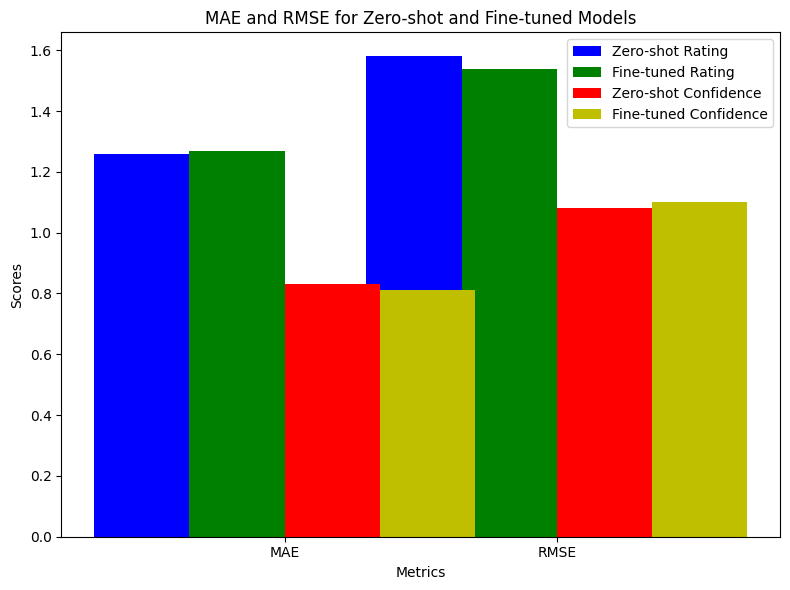

In [17]:
# Data for bar plots
metrics = ['MAE', 'RMSE']
rating_zero = [1.26, 1.58]  # Zero-shot Rating
rating_ft = [1.27, 1.54]    # Fine-tuned Rating
confidence_zero = [0.83, 1.08]  # Zero-shot Confidence
confidence_ft = [0.81, 1.10]    # Fine-tuned Confidence

bar_width = 0.35
index = np.arange(len(metrics))

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

bar1 = ax.bar(index, rating_zero, bar_width, label='Zero-shot Rating', color='b')
bar2 = ax.bar(index + bar_width, rating_ft, bar_width, label='Fine-tuned Rating', color='g')
bar3 = ax.bar(index + 2*bar_width, confidence_zero, bar_width, label='Zero-shot Confidence', color='r')
bar4 = ax.bar(index + 3*bar_width, confidence_ft, bar_width, label='Fine-tuned Confidence', color='y')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('MAE and RMSE for Zero-shot and Fine-tuned Models')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


### Scatter plots of predicted vs. true ratings to visualize linear trends and variance

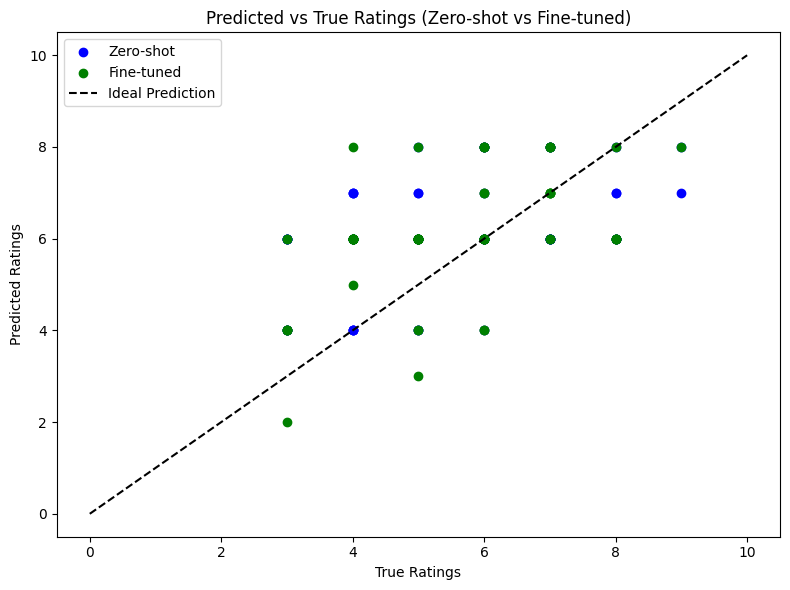

In [18]:
# Scatter plot for predicted vs true ratings
plt.figure(figsize=(8, 6))
plt.scatter(zero_eval["rating_num"], zero_eval["rating_pred"], color='b', label='Zero-shot')
plt.scatter(ft_eval["rating_num"], ft_eval["rating_pred"], color='g', label='Fine-tuned')
plt.plot([0, 10], [0, 10], 'k--', label='Ideal Prediction')
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs True Ratings (Zero-shot vs Fine-tuned)')
plt.legend()
plt.tight_layout()
plt.show()

### BERTScore comparison bar chart between zero-shot and fine-tuned outputs

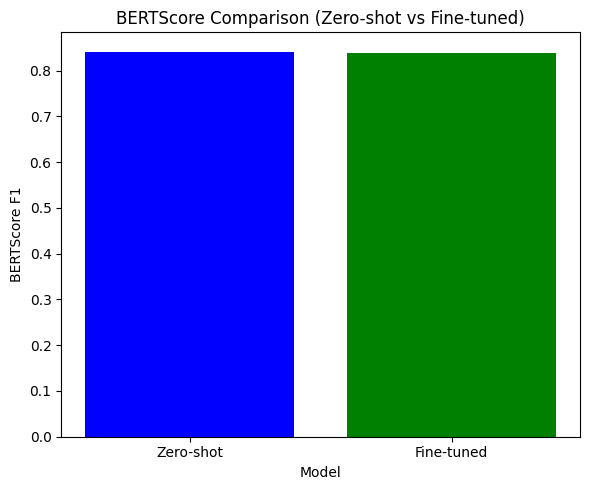

In [ ]:
# BERTScore Comparison Bar Chart
bert_scores = [0.8415, 0.8380]
labels = ['Zero-shot', 'Fine-tuned']

plt.figure(figsize=(6, 5))
plt.bar(labels, bert_scores, color=['b', 'g'])
plt.xlabel('Model')
plt.ylabel('BERTScore F1')
plt.title('BERTScore Comparison (Zero-shot vs Fine-tuned)')
plt.tight_layout()
plt.show()